#Non-stochastic control

In [1]:
import jax
import itertools
import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

from jax.numpy.linalg import inv, pinv
from scipy.linalg import solve_discrete_are as dare
from jax import jit, grad
from IPython import display
from toolz.dicttoolz import valmap, itemmap
from itertools import chain

def liveplot(costss, xss, cmax=30, cumcmax=15, wmax=2, xmax=20, logcmax=100, logcumcmax=1000):
    cummean = lambda x: np.cumsum(np.array(x))/np.arange(1, len(x)+1)
    cumcostss = valmap(cummean, costss)

    # plt.style.use('seaborn')
    colors = {
        "Zero Control": "gray",
        "LQR / H2": "green",
        "Finite-horizon LQR / H2": "teal",
        "Optimal LQG for GRW": "aqua",
        "Robust / Hinf Control": "orange",
        "GPC": "red"
    }

    fig, ax = plt.subplots(3, 2, figsize=(21, 12))

    costssline = {}
    for Cstr, costs in costss.items():
        costssline[Cstr], = ax[0, 0].plot([], label=Cstr, color=colors[Cstr])
    ax[0, 0].set_xlabel("Time")
    ax[0, 0].set_ylabel("Instantaneous Cost")
    ax[0, 0].set_ylim([-1, cmax])
    ax[0, 0].set_xlim([0, 100])
    ax[0, 0].legend()

    cumcostssline = {}
    for Cstr, costs in cumcostss.items():
        cumcostssline[Cstr], = ax[0, 1].plot([], label=Cstr, color=colors[Cstr])
    ax[0, 1].set_xlabel("Time")
    ax[0, 1].set_ylabel("Normalized Cost")
    ax[0, 1].set_ylim([-1, cumcmax])
    ax[0, 1].set_xlim([0, 100])
    ax[0, 1].legend()

    perturbline, = ax[2, 0].plot([])
    ax[2, 0].set_xlabel("Time")
    ax[2, 0].set_ylabel("Perturbation")
    ax[2, 0].set_ylim([-wmax, wmax])
    ax[2, 0].set_xlim([0, 100])

    pointssline, trailssline = {}, {}
    for Cstr, C in xss.items():
        pointssline[Cstr], = ax[2,1].plot([], [], label=Cstr, color=colors[Cstr], ms=20, marker='s')
        trailssline[Cstr], = ax[2,1].plot([], [], label=Cstr, color=colors[Cstr], lw=2)
    ax[2, 1].set_xlabel("Position")
    ax[2, 1].set_ylabel("")
    ax[2, 1].set_ylim([-1, 6])
    ax[2, 1].set_xlim([-xmax, xmax])
    ax[2, 1].legend()

    logcostssline = {}
    for Cstr, costs in costss.items():
        logcostssline[Cstr], = ax[1, 0].plot([1], label=Cstr, color=colors[Cstr])
    ax[1, 0].set_xlabel("Time")
    ax[1, 0].set_ylabel("Instantaneous Cost (Log Scale)")
    ax[1, 0].set_xlim([0, 100])
    ax[1, 0].set_ylim([0.1, logcmax])
    ax[1, 0].set_yscale('log')
    ax[1, 0].legend()

    logcumcostssline = {}
    for Cstr, costs in cumcostss.items():
        logcumcostssline[Cstr], = ax[1, 1].plot([1], label=Cstr, color=colors[Cstr])
    ax[1, 1].set_xlabel("Time")
    ax[1, 1].set_ylabel("Normalized Cost (Log Scale)")
    ax[1, 1].set_xlim([0, 100])
    ax[1, 1].set_ylim([0.1, logcumcmax])
    ax[1, 1].set_yscale('log')
    ax[1, 1].legend()

    def livedraw(t):
        for Cstr, costsline in costssline.items():
            costsline.set_data(np.arange(t), costss[Cstr][:t])
        for Cstr, cumcostsline in cumcostssline.items():
            cumcostsline.set_data(np.arange(t), cumcostss[Cstr][:t])
        perturbline.set_data(np.arange(t), W[:t, 0])
        for i, (Cstr, pointsline) in enumerate(pointssline.items()):
            pointsline.set_data(xss[Cstr][t][0], i)
        for i, (Cstr, trailsline) in enumerate(trailssline.items()):
            trailsline.set_data(list(map(lambda x: x[0], xss[Cstr][max(t-10, 0):t])), i)
        for Cstr, logcostsline in logcostssline.items():
            logcostsline.set_data(np.arange(t), costss[Cstr][:t])
        for Cstr, logcumcostsline in logcumcostssline.items():
            logcumcostsline.set_data(np.arange(t), cumcostss[Cstr][:t])
        return chain(costssline.values(), cumcostssline.values(), [perturbline], pointssline.values(), trailssline.values(), logcostssline.values(), logcumcostssline.values())

    livedraw(99)
    plt.show()

    from matplotlib import animation
    anim = animation.FuncAnimation(fig, livedraw, frames=100, interval=50, blit=True)
    from IPython.display import HTML
    display.clear_output(wait=True)
    return HTML(anim.to_html5_video())

In [2]:
dx, du, T = 2, 1, 100
A, B = np.array([[1.0, 1.0], [0.0, 1.0]]), np.array([[0.0], [1.0]])
# A, B = np.array([[0.0, 1.0], [-1.0, 2.0]]), np.array([[0.0], [1.0]])
Q, R = np.eye(dx), np.eye(du)

dyn = lambda x, u, w, t: A @ x + B @ u + w
cost = lambda x, u, t: x.T @ A @ x + u.T @ R @ u

def eval(control, W):
    x, z = np.zeros(dx), None
    for t in range(T):
        u, z = control(x, z, t)
        c = cost(x, u, t)
        yield (x, u, W[t], c)
        x = dyn(x, u, W[t], t)

In [3]:
def zero():
    return lambda x, z, t: (np.zeros(du), z)


def h2(A=A, B=B, Q=Q, R=R):
    P = dare(A, B, Q, R)
    K = - inv(R + B.T @ P @ B) @ (B.T @ P @ A)
    return lambda x, z, t: (K @ x, z)


def h2nonstat(A=A, B=B, Q=Q, R=R, T=T):
    dx, du = B.shape
    P, K = [np.zeros((dx, dx)) for _ in range(T + 1)], [np.zeros((du, dx)) for _ in range(T)]
    P[T] = Q
    for t in range(T - 1, -1, -1):
        P[t] = Q + A.T @ P[t + 1] @ A - (A.T @ P[t + 1] @ B) @ inv(R + B.T @ P[t + 1] @ B) @ (B.T @ P[t + 1] @ A)
        K[t] = - inv(R + B.T @ P[t + 1] @ B) @ (B.T @ P[t + 1] @ A)
    return lambda x, z, t: (K[t] @ x, z)


def hinf(A=A, B=B, Q=Q, R=R, T=T, gamma=1.0):
    dx, du = B.shape
    P, K = [np.zeros((dx, dx)) for _ in range(T + 1)], [np.zeros((du, dx)) for _ in range(T)], 
    P[T] = Q
    for t in range(T - 1, -1, -1):
        Lambda = np.eye(dx) + (B @ inv(R) @ B.T - gamma ** -2 * np.eye(dx)) @ P[t + 1]
        P[t] = Q + A.T @ P[t + 1] @ pinv(Lambda) @ A
        K[t] = - np.linalg.inv(R) @ B.T @ P[t + 1] @ pinv(Lambda) @ A
    return lambda x, z, t: (K[t] @ x, z)


def gpc(A=A, B=B, Q=Q, R=R, T=T, H=3, M=3, lr=0.01, dyn=dyn, cost=cost):
    dx, du = B.shape
    P = dare(A, B, Q, R)
    K = - np.array(inv(R + B.T @ P @ B) @ (B.T @ P @ A))

    def proxy(E, off, W):
        y = np.zeros(dx)
        for h in range(H):
            v = K @ y + np.tensordot(E, W[h: h + M], axes=([0, 2], [0, 1]))
            y = dyn(y, v, W[h + M], h + M)
        v = K @ y + np.tensordot(E, W[h: h + M], axes=([0, 2], [0, 1]))
        c = cost(y, v, None)
        return c

    proxygrad = jit(grad(proxy, argnums=(0, 1)))

    def gpc_u(x, z, t):
        if z is None or t == 0:
            z = np.zeros(dx), np.zeros(du), np.zeros((H + M, dx)), np.zeros((M, du, dx)), np.zeros(du)
        xprev, uprev, W, E, off = z
        W = jax.ops.index_update(W, 0, x - A @ xprev - B @ uprev)
        W = np.roll(W, -1, axis=0)
        if t >= H + M:
            Edelta, offdelta = proxygrad(E, off, W)
            E -= lr * Edelta
            off -= lr * offdelta
        u = K @ x + np.tensordot(E, W[-M:], axes=([0, 2], [0, 1])) + off
        return u, (x, u, W, E, off)

    return gpc_u

def controllers(gamma, H, M, lr):
    return {
        "Zero Control": zero(),
        "LQR / H2": h2(),
        "Finite-horizon LQR / H2": h2nonstat(),
        "Robust / Hinf Control": hinf(gamma=gamma),
        "GPC": gpc(H=H, M=M, lr=lr),
    }

## Uniform Pertrubation

In [4]:
magnitude = 2.0
W = magnitude * (onp.random.random((T, dx)) -0.5)

hinf_log_gamma = 1 
hinf_gamma = 10**(hinf_log_gamma)
gpc_lookback = 5 
gpc_memory = 5 
gpc_log_lr = -2 
gpc_lr = 10**(gpc_log_lr)

Cs = controllers(hinf_gamma, gpc_lookback, gpc_memory, gpc_lr)

traces = {Cstr: list(zip(*eval(C, W))) for Cstr, C in Cs.items()}
xss = valmap(lambda x: x[0], traces)
uss = valmap(lambda x: x[1], traces)
costss = valmap(lambda x: x[3], traces)

liveplot(costss, xss, 15, 10, 1.618, 10, 10**5, 10**4)

## Random walk Pertrubation

In [6]:
magnitude = 0.4 
W = magnitude * np.cumsum(onp.random.normal(size=(T, dx)), axis=0)
hinf_log_gamma = 5 
hinf_gamma = 10**(hinf_log_gamma)
gpc_lookback = 5 
gpc_memory = 5 
gpc_log_lr = -4 
gpc_lr = 10**(gpc_log_lr)

def h2ext(A=A, B=B, Q=Q, R=R, T=T):
    dx, du = B.shape
    Aext, Bext = np.block([[A, np.eye(dx)], [np.zeros((dx, dx)), np.eye(dx)]]), np.block([[B], [np.zeros((dx, du))]])
    Qext = np.block([[Q, np.zeros((dx, dx))], [np.zeros((dx, dx)), np.zeros((dx, dx))]])
    h2ns = h2nonstat(Aext, Bext, Qext, R, T)

    def h2ext_u(x, z, t):
        if z is None:
            z = np.zeros(dx), np.zeros(du)
        xprev, uprev = z
        w = x - A @ xprev - B @ uprev
        u, _ = h2ns(np.block([x, w]), None, t)
        return u, (x, u)
    return {"Optimal LQG for GRW": h2ext_u}

Cs = controllers(hinf_gamma, gpc_lookback, gpc_memory, gpc_lr)
Cs.update(h2ext())

traces = {Cstr: list(zip(*eval(C, W))) for Cstr, C in Cs.items()}
xss = valmap(lambda x: x[0], traces)
uss = valmap(lambda x: x[1], traces)
costss = valmap(lambda x: x[3], traces)

liveplot(costss, xss, 500, 400, 15, 20, 10**6, 10**6)

# Competitive Control


In [2]:
import cvxpy as cp 
import numpy as np 
import matplotlib.pyplot as plt

def eva(Q, x, u, R=1):
    return Q*np.linalg.norm(x)**2 + R*np.linalg.norm(u)**2

def offline_opt(x0, Q, A, B, T, w, R=1):
    x = cp.Variable((len(x0), T+1))
    u = cp.Variable((1, T))

    objective = cp.Minimize(Q * cp.sum_squares(x) + R * cp.sum_squares(u))

    constraints = [x[:, 0] == x0] 

    for t in range(0, T):
        constraints.append( x[:, t+1] == A @ x[:, t] + B @ u[:, t] + B @ w[:, t] )

    prob = cp.Problem(objective, constraints)

    result = prob.solve(verbose=False)
    if result is None:
        print('Something goes wrong!')
        
    return x.value, u.value, eva(Q, x.value, u.value)

def linear_con(Q, A, B, x0, K, w, T, R=1):
    x = np.zeros((2, T+1))
    u = np.zeros((1, T))
    x[:, 0] = x0
    for t in range(0, T):
        u[:, t] = K @ x[:, t]
        x[:, t+1] = A @ x[:, t] + B @ u[:, t] + B @ w[:, t]
    return x, u, eva(Q, x, u)

def vis(rollouts, names):
    plt.figure(figsize=(12,4*len(rollouts)))
    for index in range(len(rollouts)):
        plt.subplot(len(rollouts), 3, 3*index+1)
        plt.plot(rollouts[index][0].transpose())
        plt.legend(['x1', 'x2'])
        plt.title("x" + '(' + names[index] + ')')
        plt.subplot(len(rollouts), 3, 3*index+2)
        plt.plot(rollouts[index][1].transpose())
        plt.title("u" + '(' + names[index] + ')')
        plt.subplot(len(rollouts), 3, 3*index+3)
        plt.plot(rollouts[index][2].transpose())
        plt.title("w" + '(' + names[index] + ')')
    plt.tight_layout()
    plt.show()
 
def search_linear(Q, A, B, x0, w, T, R=1):
    loss_lin_opt = np.inf
    K_opt = np.nan
    
    a = np.linspace(-0.1, 2.1, 80) # k1
    b = np.linspace(-4.1, 0.1, 80) # k2
    for j in range(len(a)):
        for i in range(len(b)):
            K = np.array([[a[j], b[i]]])
            r = np.max(np.abs(np.linalg.eigvals(A + B @ K)))
            if r < 1:
                x_lin, u_lin, loss_lin = linear_con(Q, A, B, x0, K, w, T)
                if loss_lin < loss_lin_opt:
                    loss_lin_opt = loss_lin
                    K_opt = K
            
    K_ref = K_opt
    for i in range(20):
        for j in range(20):
            dK = np.array([[0.005*i-0.05, 0.005*j-0.05]])
            x_lin, u_lin, loss_lin = linear_con(Q, A, B, x0, K_ref+dK, w, T)
            if loss_lin < loss_lin_opt:
                loss_lin_opt = loss_lin
                K_opt = K_ref+dK
    
    x_lc, u_lc, loss_lc = linear_con(Q, A, B, x0, K_opt, w, T)

    return x_lc, u_lc, loss_lc, K_opt

In [3]:
import numpy as np 
import matplotlib.pyplot as plt

class ROBD_Controller:
    def __init__(self, x0, Q, lambda_1, lambda_2, epsilon=0, Optimistic=False, Smooth=True):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.Optimistic = Optimistic
        self.Smooth = Smooth
        self.epsilon = epsilon
        self.Q = Q
        self.x = [x0]
        self.u = [0.0]
        self.y = [0.0, 0.0]
        self.noisy_y = [0.0, 0.0]
        self.z = [x0[0, 0], x0[1, 0]]
        self.w_seq = [0.0]
        self.trace = []
    def ROBD(self, z, y):
        temp = 2*self.Q*z + self.lambda_1 * (-2*y[0] + y[1]) + self.lambda_2 * z
        return - temp / (2*self.Q + self.lambda_1 + self.lambda_2)
    
    def query(self, state, w_next=0):
        if(len(self.x) >= 2):
            last_w = (state - A @ self.x[-1] - self.u[-1] * B) 
            self.w_seq.append(last_w[1, 0]) 
        self.x.append(state)
        
        if(len(self.x) >= 3):
            last_z = 2 * self.z[-1] - self.z[-2] + self.w_seq[-1]
            self.z.append(last_z)
            last_y = self.ROBD(last_z, [self.y[-1], self.y[-2]]) 
            self.y.append(last_y)    
        
        if not self.Optimistic:
            last_z = 2 * self.z[-1] - self.z[-2] + w_next
            last_y = self.ROBD(last_z, [self.y[-1], self.y[-2]])
        else:
            if self.Smooth:
                last_z = 2 * self.z[-1] - self.z[-2] + self.w_seq[-1]
            else:
                last_z = 2 * self.z[-1] - self.z[-2]
            stationary_y = -2 * self.y[-1] + self.y[-2]
            if(stationary_y < last_z - self.epsilon):
                last_z -= self.epsilon
            elif(stationary_y > last_z + self.epsilon):
                last_z += self.epsilon
            else:
                last_z = stationary_y
            last_y = self.ROBD(last_z, [self.y[-1], self.y[-2]])
            
        last_u = last_y - 2 * self.noisy_y[-1] + self.noisy_y[-2]
        self.noisy_y.append(last_y)
        self.u.append(last_u)
        return last_u
    
    def total_cost(self, noise_seq, x0):
        total = 0.0
        state = x0
        self.trace = []
        for t in range(T):
            control_action = self.query(state, w_next=noise_seq[0, t]) #query the control action
            state = A @ state + (control_action + noise_seq[0, t]) * B #evolve
            total += Q * (np.matmul(np.transpose(state), state))[0, 0]
            total += control_action**2
            self.trace.append(state[0, 0])
        return total

In [4]:
T = 200
x0 = np.array([0.0, 0.0])
Q = 8
A = np.array([[0.0, 1.0], [-1.0, 2.0]])
B = np.array([[0.0], [1.0]])

## Uniform Perturbation

cost(OPT) = 54.74737113169474
cost(LC) = 1387.8865075442488
K* = [[ 1.07462025 -1.90525316]]
cost(LC)/cost(OPT) = 25.350742489638257


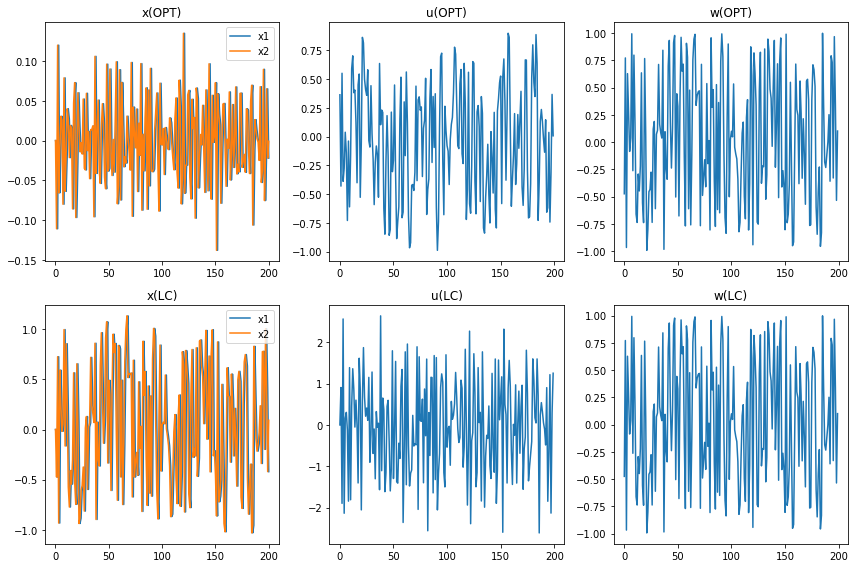

In [5]:
# Random w
w = 2 * (np.random.uniform(size=[1, T]) - 0.5)
        
x_opt, u_opt, loss_opt = offline_opt(x0, Q, A, B, T, w)
x_lc, u_lc, loss_lc, K_opt = search_linear(Q, A, B, x0, w, T)
print('cost(OPT) =', loss_opt)
print('cost(LC) =', loss_lc)
print('K* =', K_opt)
print('cost(LC)/cost(OPT) =', loss_lc/loss_opt)

vis([[x_opt, u_opt, w], [x_lc, u_lc, w]], ['OPT', 'LC'])

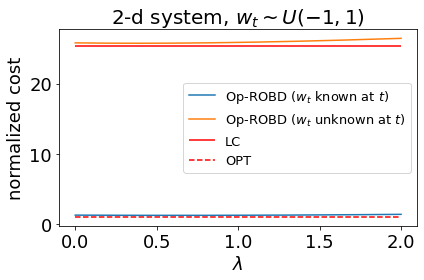

cost(OPT) = 54.74737113169474
cost(LC) = 1387.8865075442488
K* = [[ 1.07462025 -1.90525316]]
cost(LC)/cost(OPT) = 25.350742489638257
ROBD: The minimum cost is: 66.53570263399976  achieved at lambda =  0.6030150753768845
Op_ROBD: The minimum cost is: 1410.2382282913145  achieved at lambda =  0.38190954773869346


In [6]:
lam = np.linspace(0, 2, 200)
ROBD = []
Op_ROBD = []
for l in lam:
    ROBD_instance = ROBD_Controller(x0=x0.reshape([2, 1]), Q=Q, lambda_1=l, lambda_2=0.0)
    ROBD_cost = ROBD_instance.total_cost(w, x0=x0.reshape([2, 1]))
    
    Op_ROBD_instance = ROBD_Controller(x0=x0.reshape([2, 1]), Q=Q, lambda_1=l, lambda_2=0.0, epsilon=1.0, Optimistic=True, Smooth=False)
    Op_ROBD_cost = Op_ROBD_instance.total_cost(w, x0=x0.reshape([2, 1]))
    
    ROBD.append(ROBD_cost)
    Op_ROBD.append(Op_ROBD_cost)

plt.plot(lam, ROBD/loss_opt)
plt.plot(lam, Op_ROBD/loss_opt)
plt.hlines(y=loss_lc/loss_opt, xmin=lam[0], xmax=lam[-1], colors='r')
plt.hlines(y=loss_opt/loss_opt, xmin=lam[0], xmax=lam[-1], colors='r', linestyles='--')
plt.xlabel(r'$\lambda$', fontsize=18)
plt.ylabel('normalized cost', fontsize=18)
plt.legend([r'Op-ROBD ($w_t$ known at $t$)', r'Op-ROBD ($w_t$ unknown at $t$)', 'LC', 'OPT'], fontsize=13)

plt.tick_params(labelsize=18)
plt.title(r'2-d system, $w_t\sim U(-1,1)$', fontsize=20)
plt.tight_layout()
plt.show()

print('cost(OPT) =', loss_opt)
print('cost(LC) =', loss_lc)
print('K* =', K_opt)
print('cost(LC)/cost(OPT) =', loss_lc/loss_opt)
print("ROBD: The minimum cost is:", np.min(ROBD), " achieved at lambda = ", lam[np.argmin(ROBD)])
print("Op_ROBD: The minimum cost is:", np.min(Op_ROBD), " achieved at lambda = ", lam[np.argmin(Op_ROBD)])

## Random walk Perturbation

cost(OPT) = 190.51284322712237
cost(LC) = 654.3449666140095
K* = [[ 0.29487342 -3.3556962 ]]
cost(LC)/cost(OPT) = 3.43465015549594


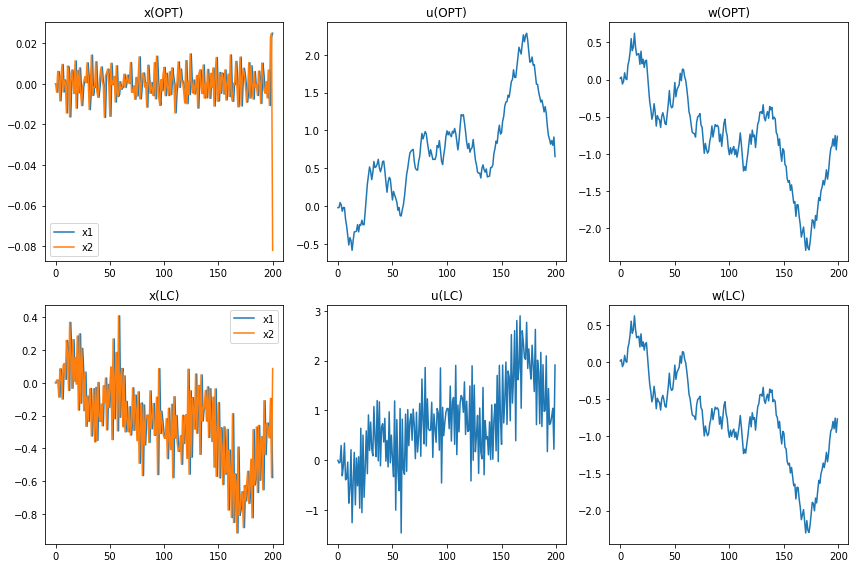

In [6]:
# Random walk w
temp = 0.4 * (np.random.uniform(size=T+1) - 0.5)
for t in range(T):
    w[0, t] = np.sum(temp[:t+1])
        
x_opt, u_opt, loss_opt = offline_opt(x0, Q, A, B, T, w)
x_lc, u_lc, loss_lc, K_opt = search_linear(Q, A, B, x0, w, T)
print('cost(OPT) =', loss_opt)
print('cost(LC) =', loss_lc)
print('K* =', K_opt)
print('cost(LC)/cost(OPT) =', loss_lc/loss_opt)

vis([[x_opt, u_opt, w], [x_lc, u_lc, w]], ['OPT', 'LC'])

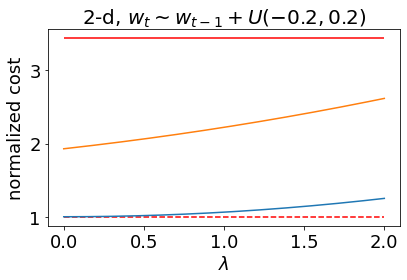

cost(OPT) = 190.51284322712237
cost(LC) = 654.3449666140095
K* = [[ 0.29487342 -3.3556962 ]]
cost(LC)/cost(OPT) = 3.43465015549594
ROBD: The minimum cost is: 190.8229585819834  achieved at lambda =  0.0
Op_ROBD: The minimum cost is: 367.4267666114862  achieved at lambda =  0.0


In [7]:
lam = np.linspace(0, 2, 200)
ROBD = []
Op_ROBD = []
for l in lam:
    ROBD_instance = ROBD_Controller(x0=x0.reshape([2, 1]), Q=Q, lambda_1=l, lambda_2=0.0)
    ROBD_cost = ROBD_instance.total_cost(w, x0=x0.reshape([2, 1]))
    
    Op_ROBD_instance = ROBD_Controller(x0=x0.reshape([2, 1]), Q=Q, lambda_1=l, lambda_2=0.0, epsilon=0.2, Optimistic=True, Smooth=True)
    Op_ROBD_cost = Op_ROBD_instance.total_cost(w, x0=x0.reshape([2, 1]))
    
    ROBD.append(ROBD_cost)
    Op_ROBD.append(Op_ROBD_cost)

plt.plot(lam, ROBD/loss_opt)
plt.plot(lam, Op_ROBD/loss_opt)
plt.hlines(y=loss_lc/loss_opt, xmin=lam[0], xmax=lam[-1], colors='r')
plt.hlines(y=loss_opt/loss_opt, xmin=lam[0], xmax=lam[-1], colors='r', linestyles='--')
plt.xlabel(r'$\lambda$', fontsize=18)
plt.ylabel('normalized cost', fontsize=18)
plt.tick_params(labelsize=18)
plt.title(r'2-d, $w_t\sim w_{t-1}+U(-0.2,0.2)$', fontsize=20)
plt.tight_layout()
plt.show()

print('cost(OPT) =', loss_opt)
print('cost(LC) =', loss_lc)
print('K* =', K_opt)
print('cost(LC)/cost(OPT) =', loss_lc/loss_opt)
print("ROBD: The minimum cost is:", np.min(ROBD), " achieved at lambda = ", lam[np.argmin(ROBD)])
print("Op_ROBD: The minimum cost is:", np.min(Op_ROBD), " achieved at lambda = ", lam[np.argmin(Op_ROBD)])

# Regret-optimal Control

In [7]:
T = 200
x0 = np.array([0.0, 0.0])
Q = 8
A = np.array([[0.0, 1.0], [-1.0, 2.0]])
B = np.array([[0.0], [1.0]])

## Uniform Perturbation

cost(OPT) = 49.24505017019427
cost(LC) = 1286.710381439948
K* = [[ 0.91253165 -1.77575949]]
cost(LC) - cost(OPT) = 1237.4653312697537


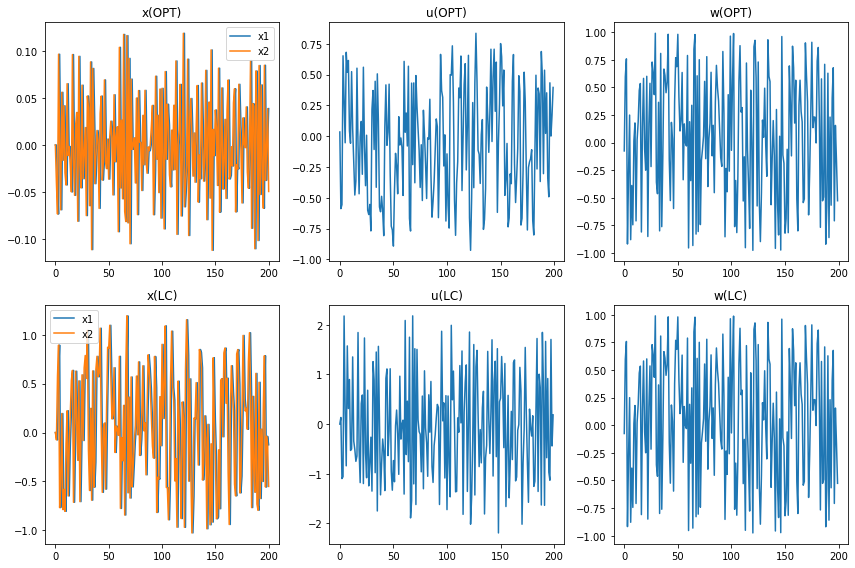

In [8]:
# Random w
w = 2 * (np.random.uniform(size=[1, T]) - 0.5)
        
x_opt, u_opt, loss_opt = offline_opt(x0, Q, A, B, T, w)
x_lc, u_lc, loss_lc, K_opt = search_linear(Q, A, B, x0, w, T)
print('cost(OPT) =', loss_opt)
print('cost(LC) =', loss_lc)
print('K* =', K_opt)
print('cost(LC) - cost(OPT) =', loss_lc - loss_opt)

vis([[x_opt, u_opt, w], [x_lc, u_lc, w]], ['OPT', 'LC'])

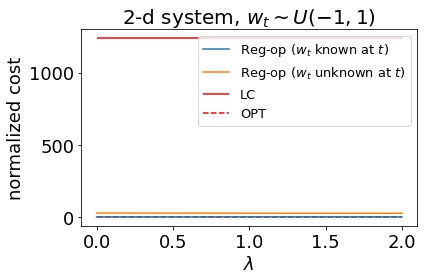

cost(OPT) = 49.24505017019427
cost(LC) = 1286.710381439948
K* = [[ 0.91253165 -1.77575949]]
cost(LC)/cost(OPT) = 1237.4653312697537
ROBD: The minimum cost is: 60.82087904660961  achieved at lambda =  0.8844221105527639
Op_ROBD: The minimum cost is: 1287.3387466154381  achieved at lambda =  1.9698492462311559


In [9]:
lam = np.linspace(0, 2, 200)
ROBD = []
Op_ROBD = []
for l in lam:
    ROBD_instance = ROBD_Controller(x0=x0.reshape([2, 1]), Q=Q, lambda_1=l, lambda_2=0.0)
    ROBD_cost = ROBD_instance.total_cost(w, x0=x0.reshape([2, 1]))
    
    Op_ROBD_instance = ROBD_Controller(x0=x0.reshape([2, 1]), Q=Q, lambda_1=l, lambda_2=0.0, epsilon=1.0, Optimistic=True, Smooth=False)
    Op_ROBD_cost = Op_ROBD_instance.total_cost(w, x0=x0.reshape([2, 1]))
    
    ROBD.append(ROBD_cost)
    Op_ROBD.append(Op_ROBD_cost)

plt.plot(lam, ROBD/loss_opt)
plt.plot(lam, Op_ROBD/loss_opt)
plt.hlines(y=loss_lc - loss_opt, xmin=lam[0], xmax=lam[-1], colors='r')
plt.hlines(y=loss_opt/ loss_opt, xmin=lam[0], xmax=lam[-1], colors='r', linestyles='--')
plt.xlabel(r'$\lambda$', fontsize=18)
plt.ylabel('normalized cost', fontsize=18)
plt.tick_params(labelsize=18)
plt.title(r'2-d system, $w_t\sim U(-1,1)$', fontsize=20)
plt.tight_layout()
plt.legend([r'Reg-op ($w_t$ known at $t$)', r'Reg-op ($w_t$ unknown at $t$)', 'LC', 'OPT'], fontsize=13)
plt.show()

print('cost(OPT) =', loss_opt)
print('cost(LC) =', loss_lc)
print('K* =', K_opt)
print('cost(LC)/cost(OPT) =', loss_lc - loss_opt)
print("ROBD: The minimum cost is:", np.min(ROBD), " achieved at lambda = ", lam[np.argmin(ROBD)])
print("Op_ROBD: The minimum cost is:", np.min(Op_ROBD), " achieved at lambda = ", lam[np.argmin(Op_ROBD)])


## Random Walk Perturbation

cost(OPT) = 91.73580822830813
cost(LC) = 349.57809235295105
K* = [[ 0.26702532 -3.20120253]]
cost(LC) - cost(OPT) = 257.8422841246429


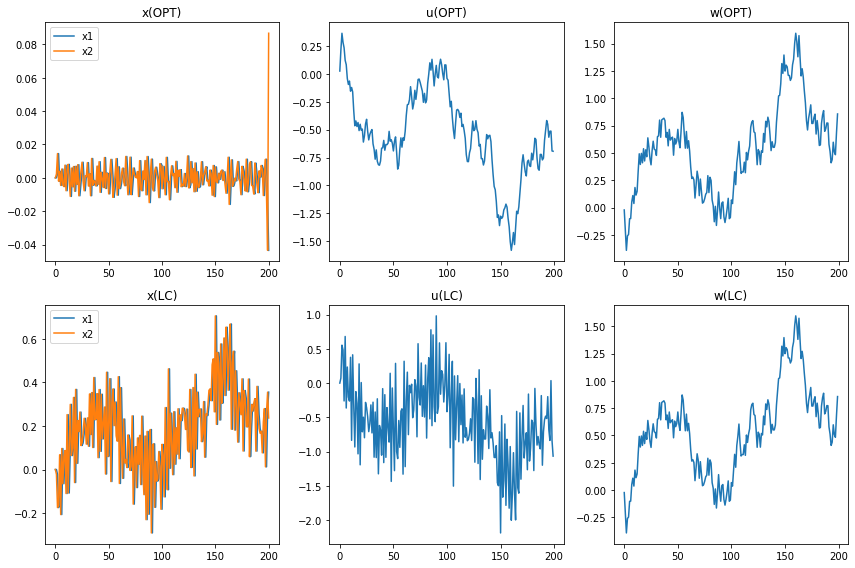

In [7]:
# Random walk w
temp = 0.4 * (np.random.uniform(size=T+1) - 0.5)
for t in range(T):
    w[0, t] = np.sum(temp[:t+1])
        
x_opt, u_opt, loss_opt = offline_opt(x0, Q, A, B, T, w)
x_lc, u_lc, loss_lc, K_opt = search_linear(Q, A, B, x0, w, T)
print('cost(OPT) =', loss_opt)
print('cost(LC) =', loss_lc)
print('K* =', K_opt)
print('cost(LC) - cost(OPT) =', loss_lc - loss_opt)

vis([[x_opt, u_opt, w], [x_lc, u_lc, w]], ['OPT', 'LC'])

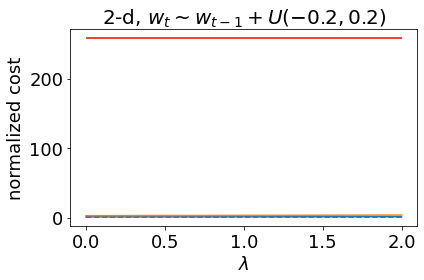

cost(OPT) = 91.73580822830813
cost(LC) = 349.57809235295105
K* = [[ 0.26702532 -3.20120253]]
cost(LC)- cost(OPT) = 257.8422841246429
ROBD: The minimum cost is: 92.08446760634831  achieved at lambda =  0.010050251256281407
Op_ROBD: The minimum cost is: 253.0337871467109  achieved at lambda =  0.0


In [8]:
lam = np.linspace(0, 2, 200)
ROBD = []
Op_ROBD = []
for l in lam:
    ROBD_instance = ROBD_Controller(x0=x0.reshape([2, 1]), Q=Q, lambda_1=l, lambda_2=0.0)
    ROBD_cost = ROBD_instance.total_cost(w, x0=x0.reshape([2, 1]))
    
    Op_ROBD_instance = ROBD_Controller(x0=x0.reshape([2, 1]), Q=Q, lambda_1=l, lambda_2=0.0, epsilon=0.2, Optimistic=True, Smooth=True)
    Op_ROBD_cost = Op_ROBD_instance.total_cost(w, x0=x0.reshape([2, 1]))
    
    ROBD.append(ROBD_cost)
    Op_ROBD.append(Op_ROBD_cost)

plt.plot(lam, ROBD/loss_opt)
plt.plot(lam, Op_ROBD/loss_opt)
plt.hlines(y=loss_lc - loss_opt, xmin=lam[0], xmax=lam[-1], colors='r')
plt.hlines(y=loss_opt/loss_opt, xmin=lam[0], xmax=lam[-1], colors='r', linestyles='--')
plt.xlabel(r'$\lambda$', fontsize=18)
plt.ylabel('normalized cost', fontsize=18)
plt.tick_params(labelsize=18)
plt.title(r'2-d, $w_t\sim w_{t-1}+U(-0.2,0.2)$', fontsize=20)
plt.tight_layout()
plt.show()

print('cost(OPT) =', loss_opt)
print('cost(LC) =', loss_lc)
print('K* =', K_opt)
print('cost(LC)- cost(OPT) =', loss_lc - loss_opt)
print("ROBD: The minimum cost is:", np.min(ROBD), " achieved at lambda = ", lam[np.argmin(ROBD)])
print("Op_ROBD: The minimum cost is:", np.min(Op_ROBD), " achieved at lambda = ", lam[np.argmin(Op_ROBD)])